In [ ]:
#Import packages

import autograd.numpy as np
from statistics import mean, median
import matplotlib.pyplot as plt
from math import log
from random import randint, uniform
from tqdm import tqdm
import copy
from autograd import grad
from autograd.numpy.linalg import inv
from matplotlib import pyplot as plt

## Monte Carlo Simulation to find expected payoffs

In [ ]:
### MONTE CARLO SIMULATION FOR IPD  ###

### Written on Sat, Feb 5 2022 ###  

#size of state space (cc, cd, dc, dd)
n = 4 

#Initialize episodic returns to empty for all s in S
returns_A = [[],[],[],[]]
returns_B = [[],[],[],[]]

#Payoff matrix
R_A = np.array([3.0,0.0,5.0,1.0])
R_B = np.array([3.0,5.0,0.0,1.0])

#Probability distribtution over state space
pi = np.array([0.25, 0.25, 0.25, 0.25])

#Pair of policiies. Shown below is tit-for-tat 
pi_A = np.array([1.0,0.0,1.0,0.0])
pi_B = np.array([1.0,1.0,0.0,0.0])

#Probability of ending the game
gamma = 0.01

#Number of espisodes
num_epi = 1000

for i in tqdm(range(num_epi)):

  epi_len = 0 #keep track of episode length

  #Sample a random start state
  s0 = np.random.choice(np.arange(4), p = pi)

  #Compute the total payoff obtained from that state following pair of policies
  payoff_A = 0
  payoff_B = 0

  #states = []
  #states.append(s0)

  while(True):

    if uniform(0,1) < gamma:
      
      payoff_A += R_A[s0]
      payoff_B += R_B[s0]
      epi_len += 1

      break

    else:

      #Find the next state based on the strategies 

      if epi_len == 0:
        p_A = pi_A[s0] #Probability of agent A cooperating when is state s
        p_B = pi_B[s0] #Probability of agent B cooperating when is state s

      else:
        p_A = pi_A[s]
        p_B = pi_B[s]

      if p_A >= 0.5:
        move_A = 'C'
      else:
        move_A = 'D'

      if p_B >= 0.5:
        move_B = 'C'
      else:
        move_B = 'D'

      #CC
      if move_A == 'C' and move_B == 'C':
        s = 0

      #CD
      elif move_A == 'C' and move_B == 'D':
        s = 1

      #DC
      elif move_A == 'D' and move_B == 'C':
        s = 2

      #DD
      else:
        s = 3

      #Increment episode length and add the incremental payoffs
      epi_len += 1
      payoff_A += R_A[s]
      payoff_B += R_B[s]

      #states.append(s)

  #A sample of an expected payoff from state 
  returns_A[s0].append(payoff_A/epi_len)
  returns_B[s0].append(payoff_B/epi_len)

#Print to screen after averaging across episodes
print("\n")
value_A = [np.average(returns_A[s]) for s in range(n)]
print("Value function for agent A in states cc, cd, dc and dd is: \n",value_A)
value_B = [np.average(returns_B[s]) for s in range(n)]
print("Value function for agent B in states cc, cd, dc and dd is: \n",value_B)

100%|██████████| 1000/1000 [00:00<00:00, 4512.29it/s]



Value function for agent A in states cc, cd, dc and dd is: 
 [3.0, 2.4341014859512233, 2.572042308549163, 1.0]
Value function for agent B in states cc, cd, dc and dd is: 
 [3.0, 2.5658985140487767, 2.427957691450837, 1.0]


## Policy Gradients to find optimal behavior 

In [ ]:
### Find the entries of transition matrix based on pairs of policies

def transition_matrix(policy_A, policy_B):

  #v1 = p.*q v2 = p.*(1-q) v3 = (1-p).*q v4 = (1-p).*(1-q), where .* denoted hadamard product
  v1 = np.multiply(policy_A, policy_B)
  v2 = np.multiply(policy_A, 1. - policy_B)
  v3 = np.multiply(1. - policy_A, policy_B)
  v4 = np.multiply(1. - policy_A, 1. - policy_B)

  #Stack the colum vectors into a matrix
  return np.vstack((v1, v2, v3, v4))

In [ ]:
#Utility function J_A for agent A using matrix expression  
def J_A(policy_A, policy_B, pi, gamma):

  #Compute gamma(I-(1-gamma)P)^-1*R_A
  P = transition_matrix(policy_A, policy_B)
  n = len(pi)
  x1 = np.identity(n)
  x2 = (gamma-1)*P
  x3 = gamma*inv(np.add(x1,x2))
  x4 = np.matmul(x3, R_A)

  #Average over starting probability distribution
  return np.dot(x4, pi)

In [ ]:
#Utility function J_B for agent B using matrix expression  
def J_B(policy_A, policy_B, pi, gamma):

  P = transition_matrix(policy_A, policy_B)
  
  n = len(pi)
  x1 = np.identity(n)
  x2 = (gamma-1)*P
  x3 = gamma*inv(np.add(x1,x2))
  x4 = np.matmul(x3, R_B)

  #Average over starting probability distribution
  return np.dot(x4, pi)

In [ ]:
JA_p = grad(J_A, 0) #Derivative of J_A w.r.t policy of agent A
JB_q = grad(J_B, 1) #Derivative of J_B w.r.t policy of agent A p

In [ ]:
### Test if autograd works

pi = np.array([0.25, 0.25, 0.3, 0.3])
pi_A = np.array([0.25, 0.25, 0.25, 0.25])
pi_B = np.array([0.25, 0.25, 0.25, 0.25])
JA_p(pi_A, pi_B, pi, 1)
JB_q(pi_A, pi_B, pi, 1)

array([0.04232794, 0.12668413, 0.1263095 , 0.37900343])

In [ ]:
def SimGD(pi_A_init, pi_B_init, alpha, pi, gamma, maxitr = 1000):

  trajectory_A = [pi_A_init]
  trajectory_B = [pi_B_init]
  
  for i in tqdm(range(maxitr)):

    #Compute gradients
    JA_p = grad(J_A, 0) 
    JB_q = grad(J_B, 1)

    #Independtently update the strategies for A and B
    pi_A_new = pi_A_init - alpha*JA_p(pi_A_init, pi_B_init, pi, gamma)
    pi_B_new = pi_B_init - alpha*JB_q(pi_A_init, pi_B_init, pi, gamma)

    #Break the loop if the policies are not changing 
    if np.linalg.norm(pi_A_new - pi_A_init) < 10**-6 and  np.linalg.norm(pi_B_new - pi_B_init) < 10**-6 :
      break

    #Cache the new strateies
    trajectory_A.append(pi_A_new)
    trajectory_B.append(pi_B_new)
    pi_A_init = pi_A_new
    pi_B_init = pi_B_new

  
  return pi_A_init, pi_B_init, trajectory_A, trajectory_B

In [ ]:
pi_A_final, pi_B_final, trajectory_A, trajectory_B = SimGD(pi_A, pi_B, 0.001, pi, gamma, 1000)

100%|██████████| 1000/1000 [00:02<00:00, 389.86it/s]


In [ ]:
pi_A_final

array([0.27305519, 0.19920351, 0.22382201, 0.44363393])

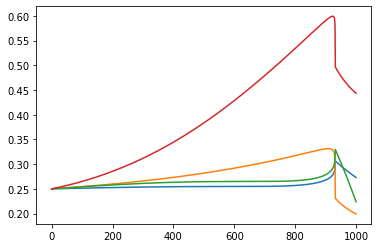

In [ ]:
plt.plot([x[0] for x in trajectory_A])
plt.plot([x[1] for x in trajectory_A])
plt.plot([x[2] for x in trajectory_A])
plt.plot([x[3] for x in trajectory_A])

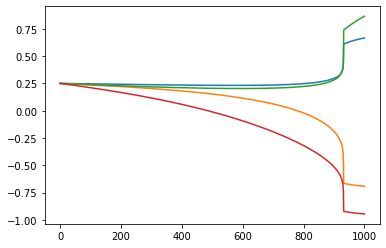

In [ ]:
plt.plot([x[0] for x in trajectory_B])
plt.plot([x[1] for x in trajectory_B])
plt.plot([x[2] for x in trajectory_B])
plt.plot([x[3] for x in trajectory_B])